# Latent Diffusion: Compressing the Problem

We've built a complete diffusion pipeline. flow matching, transformers, class conditioning, text conditioning. There's just one problem: **it doesn't scale**.

Try running our DiT on a 512×512 image. Go ahead, I'll wait. Actually, don't. your GPU will run out of memory before you can say "attention complexity."

This is where **latent diffusion** comes in. The key insight (from Rombach et al., 2022) is almost embarrassingly simple: what if we did diffusion in a *smaller* space?

## The Scaling Wall

Let's look at the numbers:

| Resolution | Pixels | Patches (4×4) | Attention Pairs |
|------------|--------|---------------|------------------|
| 32×32 | 3,072 | 64 | 4,096 |
| 64×64 | 12,288 | 256 | 65,536 |
| 256×256 | 196,608 | 4,096 | 16,777,216 |
| 512×512 | 786,432 | 16,384 | 268,435,456 |

Self-attention is $O(N^2)$ in sequence length. Going from 32×32 to 512×512 increases attention cost by **65,536×**. That's not a typo.

Even with tricks like efficient attention, this is brutal. We need a fundamentally different approach.

## The Latent Diffusion Solution

The solution has two parts:

1. **Compress** images to a small latent space using a pretrained autoencoder
2. **Diffuse** in that latent space instead of pixel space

```
Pixel-Space Diffusion:
  noise (512×512×3) ──[50 DiT steps]──> image (512×512×3)
  
Latent-Space Diffusion:
  noise (64×64×4) ──[50 DiT steps]──> latent (64×64×4) ──[VAE decode]──> image (512×512×3)
```

With 8× spatial compression:
- 512×512×3 → 64×64×4 latents
- 786,432 → 16,384 dimensions (**48× smaller**)
- 16,384 tokens → 1,024 tokens (**16× fewer**)
- Attention cost drops by **256×**

The expensive ODE integration happens in the compressed space. The autoencoder (run just once at the end) handles the decompression.

## What We'll Build

1. **Variational Autoencoder (VAE)**: The compression engine
2. **The Reparameterization Trick**: How to backpropagate through randomness
3. **Latent Flow Matching**: Our familiar pipeline, now in compressed space
4. **The Complete System**: Encode → Denoise → Decode

By the end, you'll understand exactly how Stable Diffusion works.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Part 1: The Variational Autoencoder

A VAE learns to compress images into a smaller latent space and decompress them back. But it's not just any autoencoder. it's *probabilistic*.

### Why Not a Regular Autoencoder?

A regular autoencoder learns:
$$x \xrightarrow{\text{encode}} z \xrightarrow{\text{decode}} \hat{x}$$

Train with reconstruction loss $\|x - \hat{x}\|^2$, done. But there's a problem.

The latent space of a regular autoencoder can have **holes**: regions where no training image maps to. If you sample from such a region and decode, you get garbage. The encoder just memorizes where to put each training image; it doesn't organize the space nicely.

For diffusion, this is fatal. We're going to sample noise $z \sim \mathcal{N}(0, I)$ and decode it. We need *every* region of latent space to decode to something reasonable.

### The VAE Solution: Probabilistic Encoding

A VAE encodes to a *distribution*, not a point:
$$x \xrightarrow{\text{encode}} (\mu, \sigma^2) \xrightarrow{\text{sample}} z \xrightarrow{\text{decode}} \hat{x}$$

The encoder outputs parameters of a Gaussian: mean $\mu$ and variance $\sigma^2$. We then *sample* from that Gaussian to get $z$.

### The ELBO: Reconstruction + Regularization

The VAE training objective comes from variational inference. We want to maximize the likelihood of our data, but that's intractable. Instead, we maximize a lower bound (ELBO):

$$\log p(x) \geq \underbrace{\mathbb{E}_{q(z|x)}[\log p(x|z)]}_{\text{reconstruction}} - \underbrace{D_{KL}(q(z|x) \| p(z))}_{\text{regularization}}$$

In practice, we minimize:
$$\mathcal{L}_{\text{VAE}} = \underbrace{\|x - \hat{x}\|^2}_{\text{reconstruction}} + \beta \cdot \underbrace{D_{KL}(q(z|x) \| \mathcal{N}(0, I))}_{\text{KL penalty}}$$

**Reconstruction loss**: Make the decoded output match the input.

**KL divergence**: Force the encoder distribution $q(z|x) = \mathcal{N}(\mu, \sigma^2)$ to be close to the prior $p(z) = \mathcal{N}(0, I)$.

### Why the KL Term Helps

The KL penalty:
1. **Fills holes**: Pushes all encoder distributions toward $\mathcal{N}(0, I)$, ensuring coverage
2. **Smooths the space**: Nearby points in latent space decode to similar images
3. **Enables sampling**: We can sample $z \sim \mathcal{N}(0, I)$ and decode to valid images

### KL Divergence for Gaussians

For $q(z|x) = \mathcal{N}(\mu, \sigma^2)$ and $p(z) = \mathcal{N}(0, I)$:

$$D_{KL} = -\frac{1}{2} \sum_{i=1}^{d} \left(1 + \log\sigma_i^2 - \mu_i^2 - \sigma_i^2\right)$$

Let's verify this makes sense:
- If $\mu = 0$ and $\sigma = 1$: $D_{KL} = 0$ (perfect match)
- If $\mu \neq 0$: $D_{KL}$ increases (penalizes shifted mean)
- If $\sigma \neq 1$: $D_{KL}$ increases (penalizes wrong variance)

In [2]:
# Let's verify the KL divergence formula
def kl_divergence(mu, logvar):
    """KL divergence from N(mu, sigma^2) to N(0, 1).
    
    Using log-variance for numerical stability.
    sigma^2 = exp(logvar)
    """
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

# Test different scenarios
scenarios = [
    ("μ=0, σ=1 (perfect match to prior)", 0.0, 0.0),
    ("μ=1, σ=1 (shifted mean)", 1.0, 0.0),
    ("μ=0, σ=0.5 (too narrow)", 0.0, np.log(0.25)),
    ("μ=0, σ=2.0 (too wide)", 0.0, np.log(4.0)),
    ("μ=2, σ=0.5 (shifted + narrow)", 2.0, np.log(0.25)),
]

print("KL Divergence from N(μ, σ²) to N(0, 1):")
print("=" * 55)
for name, mu_val, logvar_val in scenarios:
    mu = torch.tensor([mu_val])
    logvar = torch.tensor([logvar_val])
    kl = kl_divergence(mu, logvar).item()
    print(f"{name:40s}  KL = {kl:.4f}")

print()
print("The KL term pushes the encoder toward μ=0, σ=1.")
print("Any deviation increases the loss.")

KL Divergence from N(μ, σ²) to N(0, 1):
μ=0, σ=1 (perfect match to prior)         KL = -0.0000
μ=1, σ=1 (shifted mean)                   KL = 0.5000
μ=0, σ=0.5 (too narrow)                   KL = 0.3181
μ=0, σ=2.0 (too wide)                     KL = 0.8069
μ=2, σ=0.5 (shifted + narrow)             KL = 2.3181

The KL term pushes the encoder toward μ=0, σ=1.
Any deviation increases the loss.


### The Reparameterization Trick

Here's a problem: the encoder outputs $(\mu, \sigma^2)$, and we sample $z \sim \mathcal{N}(\mu, \sigma^2)$. But sampling is a random operation. how do we backpropagate through it?

The trick: rewrite the sampling as a deterministic function plus external noise:

$$z = \mu + \sigma \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

Now $z$ is a *deterministic* function of $\mu$, $\sigma$, and $\epsilon$. The randomness ($\epsilon$) is sampled independently and treated as a constant during backprop.

**Gradients flow through:**
$$\frac{\partial z}{\partial \mu} = 1, \quad \frac{\partial z}{\partial \sigma} = \epsilon$$

In code:
```python
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)  # σ = exp(log(σ²)/2)
    eps = torch.randn_like(std)     # ε ~ N(0, I)
    return mu + std * eps           # z = μ + σε
```

We use `logvar` (log-variance) instead of variance directly for numerical stability. it can be any real number, while variance must be positive.

In [3]:
# Demonstrate the reparameterization trick
def reparameterize(mu, logvar):
    """Sample z = μ + σε where ε ~ N(0, I)."""
    std = torch.exp(0.5 * logvar)  # σ = sqrt(exp(logvar))
    eps = torch.randn_like(std)
    return mu + std * eps

# Test
mu = torch.tensor([2.0], requires_grad=True)
logvar = torch.tensor([0.0], requires_grad=True)  # σ = 1

torch.manual_seed(42)
z = reparameterize(mu, logvar)

print(f"μ = {mu.item():.2f}")
print(f"σ = {torch.exp(0.5 * logvar).item():.2f}")
print(f"z = {z.item():.4f}")
print()

# Check gradients exist
loss = z.sum()
loss.backward()

print(f"∂z/∂μ = {mu.grad.item():.2f} (should be 1)")
print(f"∂z/∂logvar = {logvar.grad.item():.4f} (depends on ε)")
print()
print("Gradients flow through! The trick works.")

μ = 2.00
σ = 1.00
z = 2.3367

∂z/∂μ = 1.00 (should be 1)
∂z/∂logvar = 0.1683 (depends on ε)

Gradients flow through! The trick works.


## Part 2: Building and Training the VAE

Let's train a VAE on CIFAR-10 (32×32 RGB images). Our architecture:

**Encoder** (32×32 → 8×8, 4× spatial compression):
- Conv: 3 → 64 channels
- Downsample: 64 → 64, stride 2 (32→16)
- Downsample: 64 → 128, stride 2 (16→8)
- Conv: 128 → 8 (4 for μ, 4 for log σ²)

**Decoder** (8×8 → 32×32):
- Conv: 4 → 128 channels
- Upsample: 128 → 64, ×2 (8→16)
- Upsample: 64 → 64, ×2 (16→32)
- Conv: 64 → 3

**Compression:**
- Input: 32×32×3 = 3,072 values
- Latent: 8×8×4 = 256 values
- **12× compression**

In [4]:
# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

print(f"Dataset: {len(train_dataset):,} images")
print(f"Shape: {train_dataset[0][0].shape} (C, H, W)")
print(f"Range: [{train_dataset[0][0].min():.1f}, {train_dataset[0][0].max():.1f}]")

Dataset: 50,000 images
Shape: torch.Size([3, 32, 32]) (C, H, W)
Range: [-1.0, 1.0]


C:\Users\zhube\Code\intro-to-transformers\.venv\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


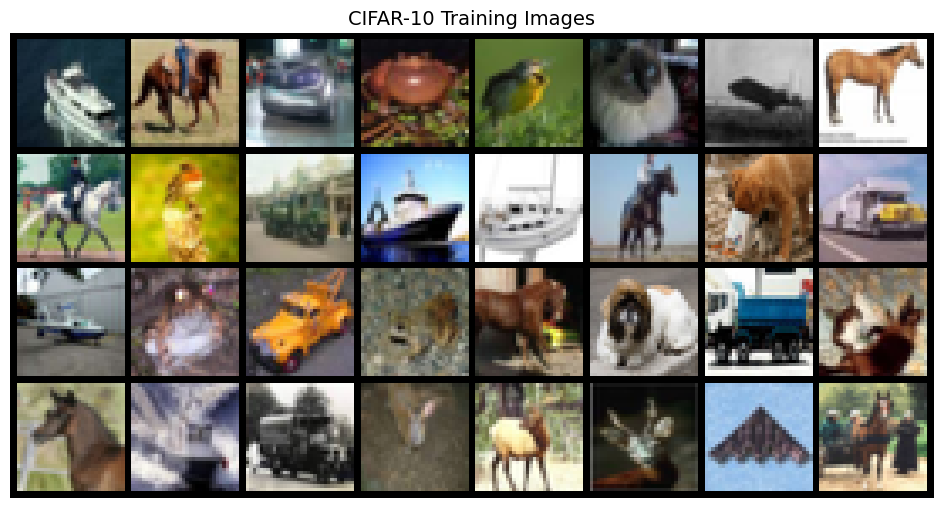

In [5]:
def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    images = (images + 1) / 2  # [-1, 1] → [0, 1]
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

sample_batch, sample_labels = next(iter(train_loader))
show_images(sample_batch[:32], title="CIFAR-10 Training Images")

In [6]:
from from_noise_to_images.vae import SmallVAE

vae = SmallVAE(
    in_channels=3,
    latent_channels=4,
    hidden_channels=64,
).to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print(f"VAE parameters: {num_params:,}")
print()

# Test forward pass
test_img = torch.randn(4, 3, 32, 32, device=device)
with torch.no_grad():
    recon, mean, logvar = vae(test_img)
    latent = vae.encode(test_img)

print("Shape analysis:")
print(f"  Input:  {test_img.shape}  ({test_img[0].numel():,} values)")
print(f"  μ, σ²:  {mean.shape}  ({mean[0].numel():,} values each)")
print(f"  Latent: {latent.shape}  ({latent[0].numel():,} values)")
print(f"  Output: {recon.shape}")
print()
print(f"Compression: {test_img[0].numel()} → {latent[0].numel()} = {test_img[0].numel() / latent[0].numel():.0f}×")

VAE parameters: 942,539

Shape analysis:
  Input:  torch.Size([4, 3, 32, 32])  (3,072 values)
  μ, σ²:  torch.Size([4, 4, 8, 8])  (256 values each)
  Latent: torch.Size([4, 4, 8, 8])  (256 values)
  Output: torch.Size([4, 3, 32, 32])

Compression: 3072 → 256 = 12×


### Choosing β: Reconstruction vs. Regularization

The loss is $\mathcal{L} = \mathcal{L}_{\text{recon}} + \beta \cdot D_{KL}$.

| β Value | Behavior | Use Case |
|---------|----------|----------|
| β = 1 | Standard VAE | General generative modeling |
| β > 1 | Disentangled latents | β-VAE for interpretable features |
| β ≪ 1 | Prioritize reconstruction | **Latent diffusion** |

For latent diffusion, we use **β ≈ 10⁻⁵**. Why so small?

1. **Reconstruction quality matters most**: The decoder needs to produce sharp images from latents
2. **The diffusion model handles generation**: We don't need to sample directly from N(0, I)
3. **Latent statistics**: We'll compute a scale factor to normalize the latent space anyway

With tiny β, the VAE is almost a regular autoencoder with a slight push toward organized latents.

In [7]:
from from_noise_to_images.train import VAETrainer

vae_trainer = VAETrainer(
    model=vae,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    kl_weight=0.00001,  # Very small β for latent diffusion
    device=device,
)

VAE_EPOCHS = 30
print(f"Training VAE for {VAE_EPOCHS} epochs")
print(f"β (KL weight) = {vae_trainer.kl_weight}")
print()

vae_losses = vae_trainer.train(num_epochs=VAE_EPOCHS)

Training VAE for 30 epochs
β (KL weight) = 1e-05

Training VAE on cuda
Model parameters: 942,539
KL weight (β): 1e-05


Epoch 1/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1: loss=0.0590, recon=0.0547, kl=431.1273


Epoch 2/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2: loss=0.0293, recon=0.0242, kl=502.6921


Epoch 3/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3: loss=0.0253, recon=0.0202, kl=503.6207


Epoch 4/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4: loss=0.0222, recon=0.0171, kl=508.3953


Epoch 5/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5: loss=0.0207, recon=0.0156, kl=505.6657


Epoch 6/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6: loss=0.0198, recon=0.0148, kl=501.7323


Epoch 7/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7: loss=0.0192, recon=0.0142, kl=498.5104


Epoch 8/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8: loss=0.0187, recon=0.0137, kl=495.4332


Epoch 9/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9: loss=0.0183, recon=0.0134, kl=492.8541


Epoch 10/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10: loss=0.0180, recon=0.0131, kl=490.3133


Epoch 11/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11: loss=0.0177, recon=0.0128, kl=487.9953


Epoch 12/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12: loss=0.0174, recon=0.0125, kl=485.8452


Epoch 13/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13: loss=0.0172, recon=0.0124, kl=483.7852


Epoch 14/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14: loss=0.0170, recon=0.0122, kl=481.8141


Epoch 15/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15: loss=0.0169, recon=0.0121, kl=480.0057


Epoch 16/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16: loss=0.0167, recon=0.0119, kl=478.1142


Epoch 17/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17: loss=0.0165, recon=0.0118, kl=476.5351


Epoch 18/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18: loss=0.0164, recon=0.0117, kl=475.1579


Epoch 19/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19: loss=0.0163, recon=0.0116, kl=473.9003


Epoch 20/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20: loss=0.0162, recon=0.0115, kl=472.7359


Epoch 21/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 21: loss=0.0161, recon=0.0114, kl=471.5786


Epoch 22/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22: loss=0.0160, recon=0.0113, kl=470.4083


Epoch 23/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23: loss=0.0159, recon=0.0112, kl=469.6460


Epoch 24/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24: loss=0.0158, recon=0.0112, kl=468.9275


Epoch 25/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 25: loss=0.0158, recon=0.0111, kl=468.1459


Epoch 26/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 26: loss=0.0157, recon=0.0110, kl=467.5998


Epoch 27/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 27: loss=0.0156, recon=0.0110, kl=466.9407


Epoch 28/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 28: loss=0.0156, recon=0.0109, kl=466.3950


Epoch 29/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 29: loss=0.0155, recon=0.0108, kl=465.9529


Epoch 30/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 30: loss=0.0155, recon=0.0108, kl=465.5851

Computing latent scale factor...


Scale factor: 0.9689


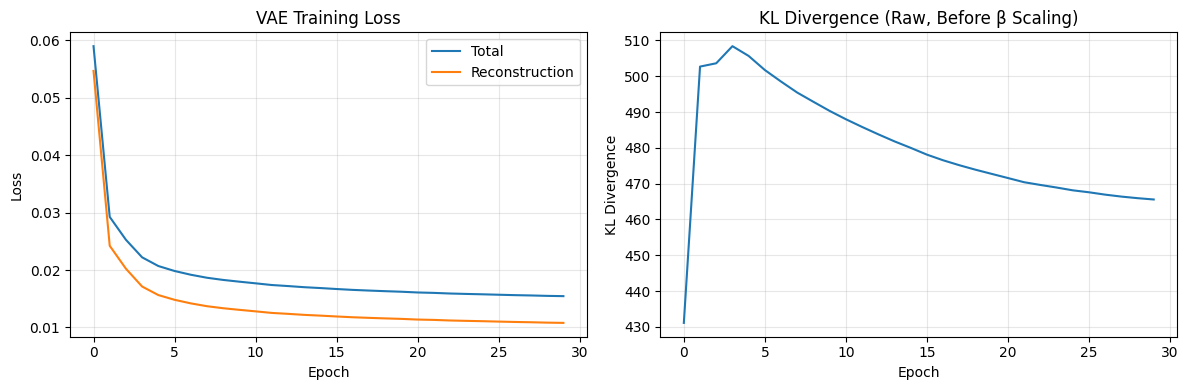

Final reconstruction loss: 0.0108
Final KL (raw): 465.6
Final KL (weighted): 0.004656


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(vae_trainer.losses, label='Total')
axes[0].plot(vae_trainer.recon_losses, label='Reconstruction')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('VAE Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(vae_trainer.kl_losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('KL Divergence')
axes[1].set_title('KL Divergence (Raw, Before β Scaling)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final reconstruction loss: {vae_trainer.recon_losses[-1]:.4f}")
print(f"Final KL (raw): {vae_trainer.kl_losses[-1]:.1f}")
print(f"Final KL (weighted): {vae_trainer.kl_losses[-1] * vae_trainer.kl_weight:.6f}")

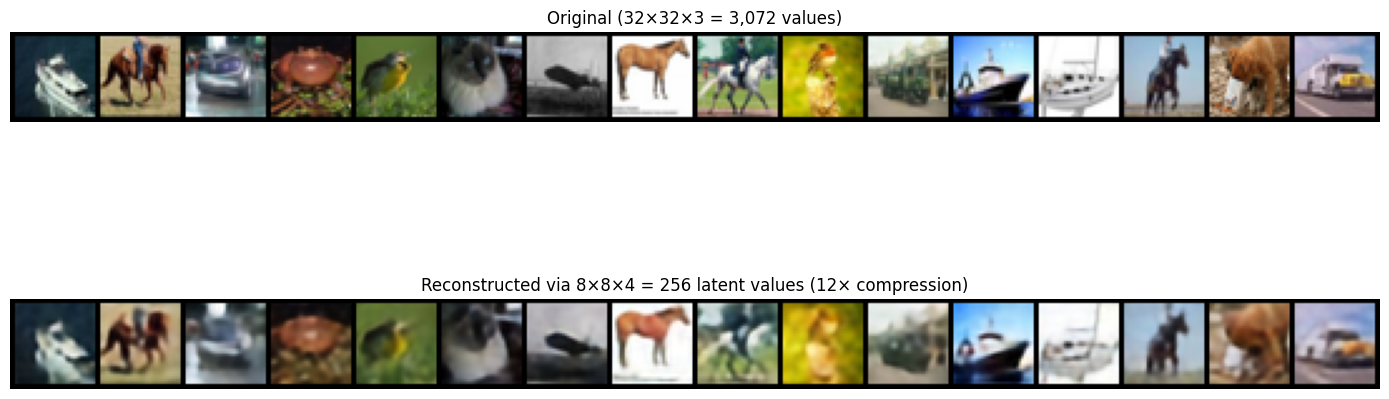

Reconstruction MSE: 0.0113


In [9]:
# Visualize reconstructions
vae.eval()

test_batch = sample_batch[:16].to(device)

with torch.no_grad():
    recon, _, _ = vae(test_batch)

fig, axes = plt.subplots(2, 1, figsize=(14, 7))

original_grid = torchvision.utils.make_grid((test_batch + 1) / 2, nrow=16, padding=2)
axes[0].imshow(original_grid.permute(1, 2, 0).cpu().numpy())
axes[0].set_title('Original (32×32×3 = 3,072 values)', fontsize=12)
axes[0].axis('off')

recon_grid = torchvision.utils.make_grid((recon + 1) / 2, nrow=16, padding=2)
axes[1].imshow(recon_grid.permute(1, 2, 0).cpu().clamp(0, 1).numpy())
axes[1].set_title('Reconstructed via 8×8×4 = 256 latent values (12× compression)', fontsize=12)
axes[1].axis('off')

plt.tight_layout()
plt.show()

mse = F.mse_loss(recon, test_batch).item()
print(f"Reconstruction MSE: {mse:.4f}")

## Part 3: Exploring the Latent Space

Before we do diffusion, let's understand what the latent space looks like.

### Scale Factor

Remember, we used a tiny β, so the latent space isn't perfectly $\mathcal{N}(0, I)$. We need to normalize it.

After training, we compute the empirical standard deviation:
$$\sigma_{\text{data}} = \text{std}(\{\text{encode}(x) : x \in \text{training set}\})$$

Then normalize latents:
$$z_{\text{normalized}} = z / \sigma_{\text{data}}$$

This ensures the latent space roughly matches the noise distribution $\mathcal{N}(0, I)$ we'll use for flow matching.

In [10]:
# Analyze latent space statistics
vae.eval()

all_means = []
all_stds = []

with torch.no_grad():
    for i, (images, _) in enumerate(train_loader):
        if i >= 50:
            break
        images = images.to(device)
        z = vae.encode(images, sample=False)  # Use mean (no sampling noise)
        all_means.append(z.mean().item())
        all_stds.append(z.std().item())

avg_mean = np.mean(all_means)
avg_std = np.mean(all_stds)

print("Latent Space Statistics (before normalization):")
print(f"  Mean: {avg_mean:.4f} (target: 0)")
print(f"  Std:  {avg_std:.4f} (will normalize to ~1)")
print()
print(f"VAE computed scale factor: {vae.scale_factor.item():.4f}")
print("(Latents are divided by this during encoding)")

Latent Space Statistics (before normalization):
  Mean: -0.0137 (target: 0)
  Std:  0.9991 (will normalize to ~1)

VAE computed scale factor: 0.9689
(Latents are divided by this during encoding)


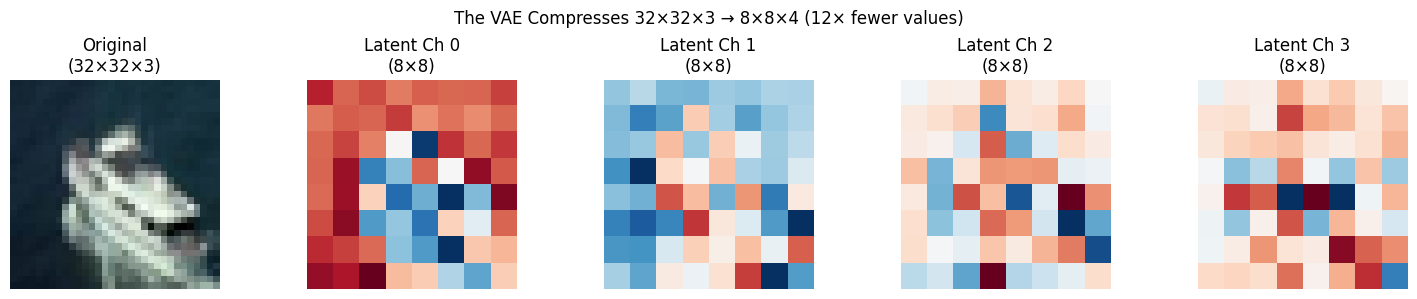

Latent shape: torch.Size([1, 4, 8, 8])
Latent range: [-2.47, 3.14]

Each 8×8 channel captures different aspects of the image.
The decoder learns to reconstruct the full image from these 256 numbers.


In [11]:
# Visualize what the latent channels capture
test_img = sample_batch[0:1].to(device)

with torch.no_grad():
    z = vae.encode(test_img, sample=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Original
axes[0].imshow((test_img[0].cpu().permute(1, 2, 0) + 1) / 2)
axes[0].set_title('Original\n(32×32×3)')
axes[0].axis('off')

# Each latent channel
for i in range(4):
    latent_ch = z[0, i].cpu().numpy()
    axes[i+1].imshow(latent_ch, cmap='RdBu', vmin=-2, vmax=2)
    axes[i+1].set_title(f'Latent Ch {i}\n(8×8)')
    axes[i+1].axis('off')

plt.suptitle('The VAE Compresses 32×32×3 → 8×8×4 (12× fewer values)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Latent shape: {z.shape}")
print(f"Latent range: [{z.min():.2f}, {z.max():.2f}]")
print()
print("Each 8×8 channel captures different aspects of the image.")
print("The decoder learns to reconstruct the full image from these 256 numbers.")

## Part 4: Flow Matching in Latent Space

Now for the main event. We'll train a DiT to do flow matching, but in the **latent space** instead of pixel space.

### The Key Substitution

Everything works exactly as before, just with latents instead of pixels:

| Pixel Space | Latent Space |
|-------------|---------------|
| $x_0$ = image | $z_0$ = encode(image) |
| $x_1 \sim \mathcal{N}(0, I)$ | $z_1 \sim \mathcal{N}(0, I)$ |
| $x_t = (1-t)x_0 + tx_1$ | $z_t = (1-t)z_0 + tz_1$ |
| $v = x_1 - x_0$ | $v = z_1 - z_0$ |
| Generate $x$ directly | Generate $z$, then decode |

### DiT for Latent Space

The DiT now operates on the smaller latent shape:
- `in_channels=4` (latent channels, not RGB)
- `img_size=8` (latent spatial size, not image size)
- `patch_size=2` → 16 tokens (not 64)

### The Computational Win

| Metric | Pixel Space | Latent Space | Reduction |
|--------|-------------|--------------|------------|
| Input size | 32×32×3 = 3,072 | 8×8×4 = 256 | 12× |
| Tokens (patch=2) | 16×16 = 256 | 4×4 = 16 | 16× |
| Attention pairs | 65,536 | 256 | **256×** |

In [12]:
from from_noise_to_images.dit import DiT

# DiT for latent space
latent_dit = DiT(
    img_size=8,           # Latent spatial size
    patch_size=2,         # 2×2 patches → 4×4 = 16 tokens
    in_channels=4,        # Latent channels
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=4.0,
).to(device)

latent_dit_params = sum(p.numel() for p in latent_dit.parameters())

# For comparison: pixel-space DiT
pixel_dit = DiT(
    img_size=32,
    patch_size=4,
    in_channels=3,
    embed_dim=256,
    depth=6,
    num_heads=8,
)
pixel_dit_params = sum(p.numel() for p in pixel_dit.parameters())

print("Comparison:")
print(f"  Pixel-space DiT: {pixel_dit_params:,} params, {8*8}=64 tokens")
print(f"  Latent-space DiT: {latent_dit_params:,} params, {4*4}=16 tokens")
print()
print(f"Token reduction: {64/16:.0f}×")
print(f"Attention cost reduction: {(64*64)/(16*16):.0f}×")
print()
print("Same parameter count, but 16× fewer attention computations per step!")

Comparison:
  Pixel-space DiT: 12,368,176 params, 64=64 tokens
  Latent-space DiT: 12,351,760 params, 16=16 tokens

Token reduction: 4×
Attention cost reduction: 16×

Same parameter count, but 16× fewer attention computations per step!


In [13]:
from from_noise_to_images.train import LatentDiffusionTrainer

latent_trainer = LatentDiffusionTrainer(
    model=latent_dit,
    vae=vae,  # VAE is frozen, used only for encoding
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    device=device,
)

LATENT_EPOCHS = 30
print(f"Training Latent DiT for {LATENT_EPOCHS} epochs")
print("VAE is frozen. Only DiT parameters are trained.")
print()

latent_losses = latent_trainer.train(num_epochs=LATENT_EPOCHS)

Training Latent DiT for 30 epochs
VAE is frozen. Only DiT parameters are trained.

Training Latent Diffusion on cuda
DiT parameters: 12,351,760
VAE parameters: 0 (frozen)


Epoch 1/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1: avg_loss = 1.6262


Epoch 2/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2: avg_loss = 1.4547


Epoch 3/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3: avg_loss = 1.4348


Epoch 4/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4: avg_loss = 1.4271


Epoch 5/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5: avg_loss = 1.4167


Epoch 6/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6: avg_loss = 1.4126


Epoch 7/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7: avg_loss = 1.4075


Epoch 8/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8: avg_loss = 1.4012


Epoch 9/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9: avg_loss = 1.3978


Epoch 10/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10: avg_loss = 1.3940


Epoch 11/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11: avg_loss = 1.3927


Epoch 12/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12: avg_loss = 1.3877


Epoch 13/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13: avg_loss = 1.3873


Epoch 14/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14: avg_loss = 1.3828


Epoch 15/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15: avg_loss = 1.3806


Epoch 16/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16: avg_loss = 1.3763


Epoch 17/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17: avg_loss = 1.3742


Epoch 18/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18: avg_loss = 1.3716


Epoch 19/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19: avg_loss = 1.3705


Epoch 20/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20: avg_loss = 1.3665


Epoch 21/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 21: avg_loss = 1.3657


Epoch 22/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22: avg_loss = 1.3649


Epoch 23/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23: avg_loss = 1.3631


Epoch 24/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24: avg_loss = 1.3622


Epoch 25/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 25: avg_loss = 1.3597


Epoch 26/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 26: avg_loss = 1.3587


Epoch 27/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 27: avg_loss = 1.3585


Epoch 28/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 28: avg_loss = 1.3555


Epoch 29/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 29: avg_loss = 1.3539


Epoch 30/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 30: avg_loss = 1.3547


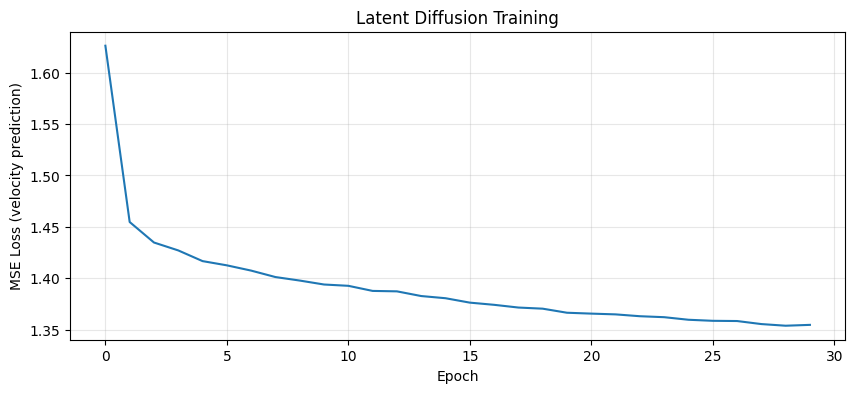

Final loss: 1.3547


In [14]:
plt.figure(figsize=(10, 4))
plt.plot(latent_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (velocity prediction)')
plt.title('Latent Diffusion Training')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {latent_losses[-1]:.4f}")

## Part 5: Sampling from Latent Space

Generation in latent diffusion:

1. **Sample noise in latent space**: $z_1 \sim \mathcal{N}(0, I)$, shape (4, 8, 8)
2. **Integrate ODE**: $z_1 \to z_0$ using learned velocity
3. **Decode to pixels**: $x = \text{decode}(z_0)$, shape (3, 32, 32)

All the expensive ODE steps (50 forward passes) happen in the small 256-dimensional latent space. The VAE decode (one forward pass) happens only at the end.

Generation pipeline:
  1. Sample z₁ ~ N(0, I) in latent space (4×8×8 = 256 dim)
  2. ODE: z₁ → z₀ via 50 Euler steps
  3. Decode: z₀ → image via VAE (3×32×32 = 3,072 dim)



Sampling (Latent):   0%|          | 0/50 [00:00<?, ?it/s]

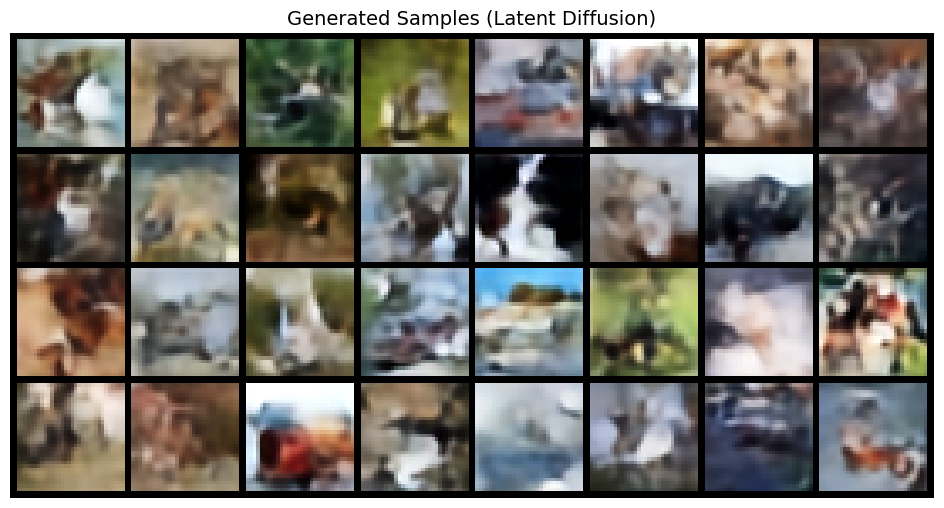

In [15]:
from from_noise_to_images.sampling import sample_latent

latent_dit.eval()
vae.eval()

print("Generation pipeline:")
print("  1. Sample z₁ ~ N(0, I) in latent space (4×8×8 = 256 dim)")
print("  2. ODE: z₁ → z₀ via 50 Euler steps")
print("  3. Decode: z₀ → image via VAE (3×32×32 = 3,072 dim)")
print()

with torch.no_grad():
    generated = sample_latent(
        model=latent_dit,
        vae=vae,
        num_samples=32,
        latent_shape=(4, 8, 8),
        num_steps=50,
        device=device,
    )

show_images(generated, nrow=8, title="Generated Samples (Latent Diffusion)")

Sampling (Latent):   0%|          | 0/50 [00:00<?, ?it/s]

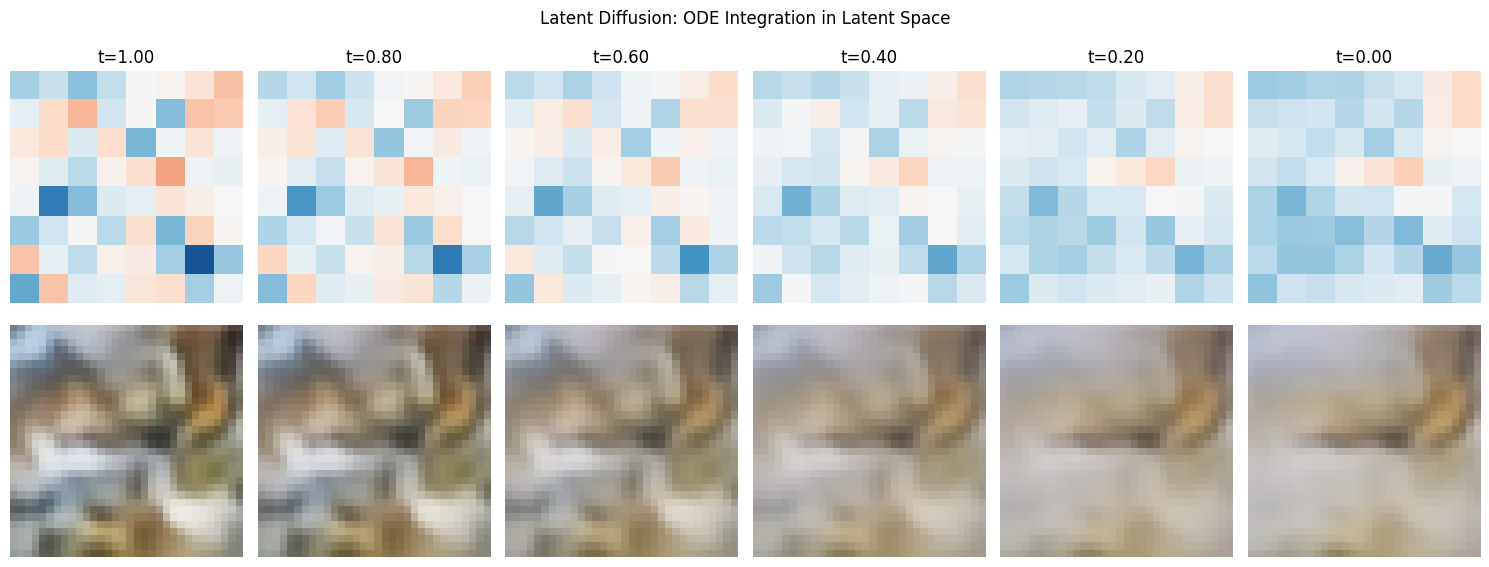

At t=1: Pure noise in latent space → noisy decode
At t→0: Structure emerges in latent → coherent image

The key insight: all 50 ODE steps happen in 256-dim space,
not 3,072-dim pixel space. That's the efficiency win.


In [16]:
# Visualize the generation process
with torch.no_grad():
    generated, trajectory = sample_latent(
        model=latent_dit,
        vae=vae,
        num_samples=4,
        latent_shape=(4, 8, 8),
        num_steps=50,
        device=device,
        return_trajectory=True,
    )

# Show evolution
steps_to_show = [0, 10, 20, 30, 40, 50]
fig, axes = plt.subplots(2, len(steps_to_show), figsize=(15, 6))

for col, step_idx in enumerate(steps_to_show):
    t_val = 1.0 - step_idx / 50
    
    # Latent (first channel)
    latent = trajectory[step_idx][0, 0].cpu().numpy()
    axes[0, col].imshow(latent, cmap='RdBu', vmin=-3, vmax=3)
    axes[0, col].set_title(f't={t_val:.2f}')
    axes[0, col].axis('off')
    
    # Decoded image
    with torch.no_grad():
        decoded = vae.decode(trajectory[step_idx][:1])
    img = (decoded[0].cpu().permute(1, 2, 0) + 1) / 2
    axes[1, col].imshow(img.clamp(0, 1).numpy())
    axes[1, col].axis('off')

axes[0, 0].set_ylabel('Latent\n(8×8)', fontsize=10)
axes[1, 0].set_ylabel('Decoded\n(32×32)', fontsize=10)

plt.suptitle('Latent Diffusion: ODE Integration in Latent Space', fontsize=12)
plt.tight_layout()
plt.show()

print("At t=1: Pure noise in latent space → noisy decode")
print("At t→0: Structure emerges in latent → coherent image")
print()
print("The key insight: all 50 ODE steps happen in 256-dim space,")
print("not 3,072-dim pixel space. That's the efficiency win.")

## Part 6: Class-Conditional Latent Diffusion

We can add conditioning to latent diffusion just like we did in the pixel-space version. The architecture is identical. we're just operating on latent shapes.

In [17]:
from from_noise_to_images.dit import ConditionalDiT

cond_latent_dit = ConditionalDiT(
    num_classes=10,       # CIFAR-10
    img_size=8,           # Latent spatial size
    patch_size=2,
    in_channels=4,        # Latent channels
    embed_dim=256,
    depth=6,
    num_heads=8,
    mlp_ratio=4.0,
).to(device)

print(f"Conditional Latent DiT: {sum(p.numel() for p in cond_latent_dit.parameters()):,} params")

Conditional Latent DiT: 12,363,024 params


In [18]:
from from_noise_to_images.train import LatentConditionalTrainer

cond_latent_trainer = LatentConditionalTrainer(
    model=cond_latent_dit,
    vae=vae,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    label_drop_prob=0.1,  # 10% dropout for CFG
    num_classes=10,
    device=device,
)

COND_EPOCHS = 30
print(f"Training Conditional Latent DiT for {COND_EPOCHS} epochs")
print(f"Label dropout: 10% (for Classifier-Free Guidance)")
print()

cond_losses = cond_latent_trainer.train(num_epochs=COND_EPOCHS)

Training Conditional Latent DiT for 30 epochs
Label dropout: 10% (for Classifier-Free Guidance)

Training Latent Conditional Diffusion on cuda
DiT parameters: 12,363,024
CFG label dropout: 10%


Epoch 1/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1: avg_loss = 1.6290


Epoch 2/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2: avg_loss = 1.4465


Epoch 3/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3: avg_loss = 1.4258


Epoch 4/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4: avg_loss = 1.4159


Epoch 5/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5: avg_loss = 1.4078


Epoch 6/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6: avg_loss = 1.4021


Epoch 7/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7: avg_loss = 1.3988


Epoch 8/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8: avg_loss = 1.3929


Epoch 9/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9: avg_loss = 1.3873


Epoch 10/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 10: avg_loss = 1.3847


Epoch 11/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 11: avg_loss = 1.3813


Epoch 12/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 12: avg_loss = 1.3765


Epoch 13/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 13: avg_loss = 1.3756


Epoch 14/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 14: avg_loss = 1.3731


Epoch 15/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 15: avg_loss = 1.3697


Epoch 16/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 16: avg_loss = 1.3655


Epoch 17/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 17: avg_loss = 1.3643


Epoch 18/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 18: avg_loss = 1.3620


Epoch 19/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 19: avg_loss = 1.3600


Epoch 20/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 20: avg_loss = 1.3555


Epoch 21/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 21: avg_loss = 1.3545


Epoch 22/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 22: avg_loss = 1.3524


Epoch 23/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 23: avg_loss = 1.3520


Epoch 24/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 24: avg_loss = 1.3499


Epoch 25/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 25: avg_loss = 1.3485


Epoch 26/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 26: avg_loss = 1.3468


Epoch 27/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 27: avg_loss = 1.3436


Epoch 28/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 28: avg_loss = 1.3438


Epoch 29/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 29: avg_loss = 1.3429


Epoch 30/30:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 30: avg_loss = 1.3406


Generating one sample per class with CFG=3.0...



Sampling (Latent CFG):   0%|          | 0/50 [00:00<?, ?it/s]

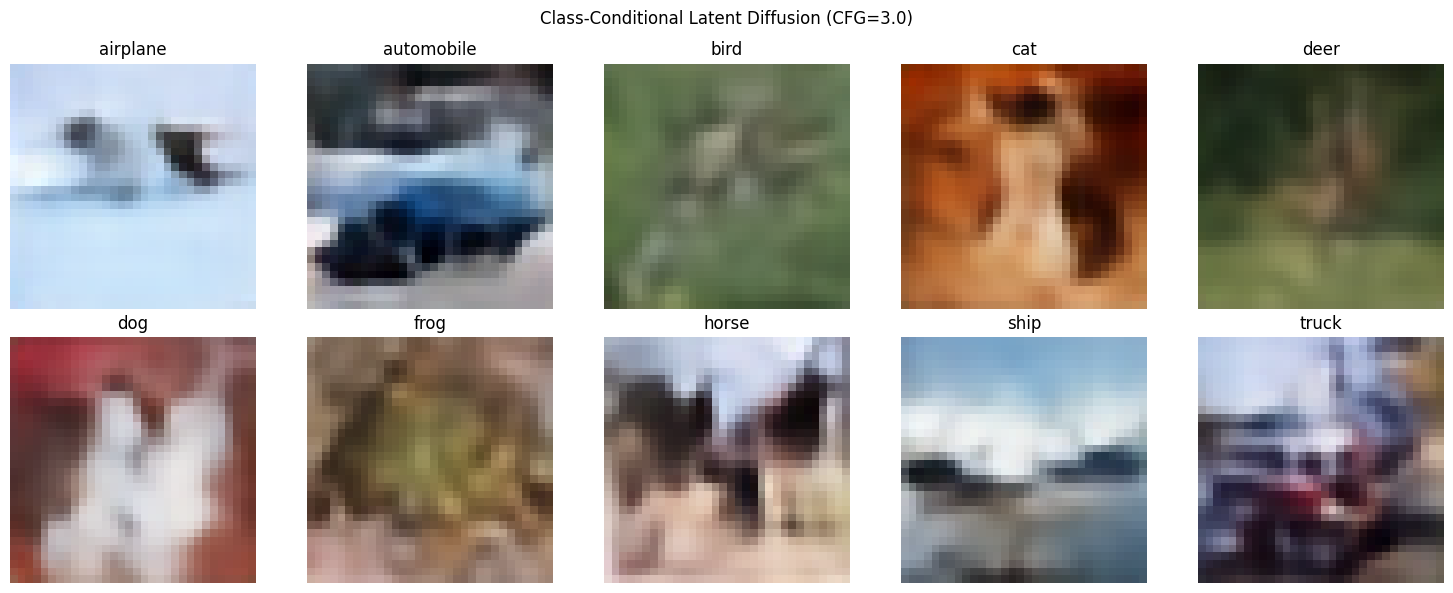

In [19]:
from from_noise_to_images.sampling import sample_latent_conditional

CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

cond_latent_dit.eval()

print("Generating one sample per class with CFG=3.0...")
print()

with torch.no_grad():
    class_samples = sample_latent_conditional(
        model=cond_latent_dit,
        vae=vae,
        class_labels=list(range(10)),
        latent_shape=(4, 8, 8),
        num_steps=50,
        cfg_scale=3.0,
        device=device,
        num_classes=10,
    )

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (ax, class_name) in enumerate(zip(axes.flat, CIFAR10_CLASSES)):
    img = (class_samples[i].cpu().permute(1, 2, 0) + 1) / 2
    ax.imshow(img.clamp(0, 1).numpy())
    ax.set_title(class_name)
    ax.axis('off')

plt.suptitle('Class-Conditional Latent Diffusion (CFG=3.0)', fontsize=12)
plt.tight_layout()
plt.show()

Sampling (Latent CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Latent CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Latent CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Latent CFG):   0%|          | 0/50 [00:00<?, ?it/s]

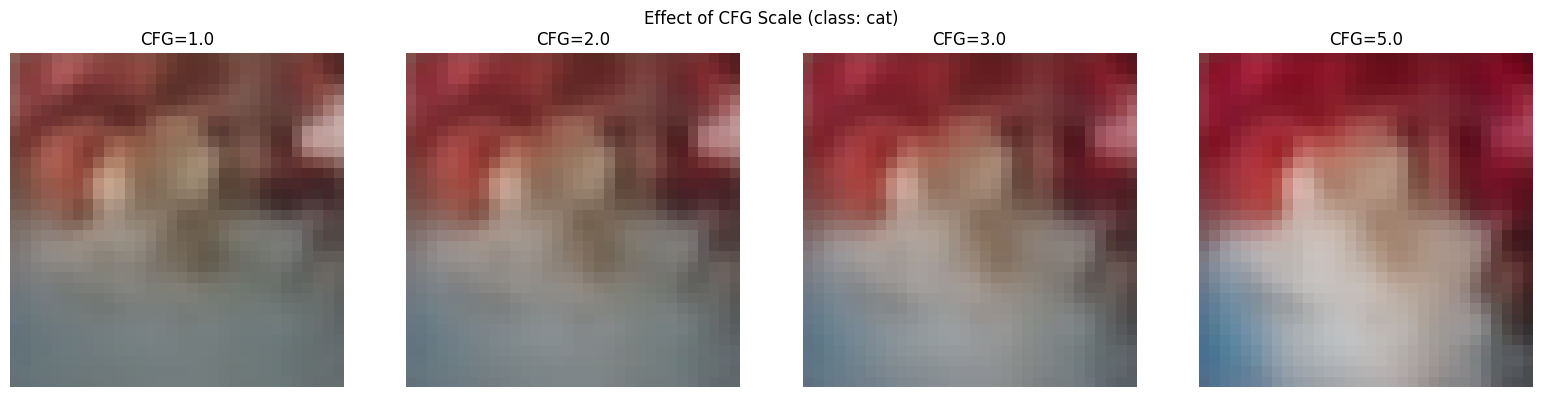

Higher CFG → stronger class adherence
Too high → less diversity, potential artifacts


In [20]:
# Compare CFG scales
cfg_scales = [1.0, 2.0, 3.0, 5.0]
target_class = 3  # cat

fig, axes = plt.subplots(1, len(cfg_scales), figsize=(16, 4))

for ax, scale in zip(axes, cfg_scales):
    torch.manual_seed(42)  # Same seed for fair comparison
    
    with torch.no_grad():
        sample = sample_latent_conditional(
            model=cond_latent_dit,
            vae=vae,
            class_labels=[target_class],
            latent_shape=(4, 8, 8),
            num_steps=50,
            cfg_scale=scale,
            device=device,
        )
    
    img = (sample[0].cpu().permute(1, 2, 0) + 1) / 2
    ax.imshow(img.clamp(0, 1).numpy())
    ax.set_title(f'CFG={scale}')
    ax.axis('off')

plt.suptitle(f'Effect of CFG Scale (class: {CIFAR10_CLASSES[target_class]})', fontsize=12)
plt.tight_layout()
plt.show()

print("Higher CFG → stronger class adherence")
print("Too high → less diversity, potential artifacts")

## Part 7: The Efficiency Win

Let's quantify the computational advantage.

In [21]:
import time

num_samples = 16
num_steps = 50

# Latent diffusion timing
torch.cuda.synchronize() if torch.cuda.is_available() else None
start = time.time()

with torch.no_grad():
    _ = sample_latent(
        model=latent_dit,
        vae=vae,
        num_samples=num_samples,
        latent_shape=(4, 8, 8),
        num_steps=num_steps,
        device=device,
    )

torch.cuda.synchronize() if torch.cuda.is_available() else None
latent_time = time.time() - start

print(f"Latent Diffusion: {num_samples} samples, {num_steps} steps")
print(f"  Total time: {latent_time:.2f}s")
print(f"  Per image: {latent_time/num_samples*1000:.1f}ms")
print()
print("Breakdown:")
print(f"  ODE steps: {num_steps} × {num_samples} = {num_steps * num_samples} DiT forward passes")
print(f"  Each on 16 tokens (256 attention pairs)")
print(f"  VAE decode: {num_samples} passes (once at the end)")

Sampling (Latent):   0%|          | 0/50 [00:00<?, ?it/s]

Latent Diffusion: 16 samples, 50 steps
  Total time: 0.21s
  Per image: 12.9ms

Breakdown:
  ODE steps: 50 × 16 = 800 DiT forward passes
  Each on 16 tokens (256 attention pairs)
  VAE decode: 16 passes (once at the end)


## Summary: The Complete Latent Diffusion Architecture

### The Big Picture

```
TRAINING:
  Image x ──[VAE Encode]──> z₀ ──[interpolate with noise]──> z_t ──[DiT]──> v̂
                                                                      │
                                              Loss = ║v̂ - (z₁ - z₀)║²

INFERENCE:
  Noise z₁ ──[DiT + ODE integration]──> z₀ ──[VAE Decode]──> Image x
```

### Key Equations

| Component | Equation | Purpose |
|-----------|----------|----------|
| VAE Encode | $z = \mu + \sigma \epsilon$ | Compress to latent |
| VAE Decode | $\hat{x} = D(z)$ | Reconstruct image |
| VAE Loss | $\mathcal{L} = \|x-\hat{x}\|^2 + \beta D_{KL}$ | Train compression |
| Interpolation | $z_t = (1-t)z_0 + tz_1$ | Flow path in latent space |
| Target velocity | $v = z_1 - z_0$ | What DiT predicts |
| Training loss | $\mathcal{L} = \|v_\theta(z_t, t) - v\|^2$ | Train DiT |
| Generation ODE | $\frac{dz}{dt} = -v_\theta(z_t, t)$ | Integrate from noise |

### Compression Ratios in Practice

| Image Size | Pixel Dims | Latent Dims (8× spatial) | Compression |
|------------|------------|--------------------------|-------------|
| 32×32×3 | 3,072 | 4×4×4 = 64 | 48× |
| 64×64×3 | 12,288 | 8×8×4 = 256 | 48× |
| 256×256×3 | 196,608 | 32×32×4 = 4,096 | 48× |
| 512×512×3 | 786,432 | 64×64×4 = 16,384 | 48× |

(Our CIFAR-10 VAE uses 4× spatial compression, so 12× total.)

### Why Latent Diffusion Works

1. **Perceptual compression**: VAEs compress semantically. nearby latents decode to similar images
2. **High-frequency details**: The decoder handles fine details; the diffusion model only needs coarse structure
3. **Computational efficiency**: 48× fewer dimensions → orders of magnitude faster
4. **Same quality**: With a good VAE, no perceptual quality loss

### This Is Stable Diffusion

You've now implemented the core of Stable Diffusion:

| Component | Stable Diffusion | Our Implementation |
|-----------|------------------|--------------------|
| Autoencoder | KL-VAE (pretrained) | SmallVAE |
| Denoiser | U-Net (or DiT in SD3) | DiT |
| Text encoder | CLIP | (Notebook 04) |
| Conditioning | Cross-attention | adaLN / Cross-attention |
| Sampling | DDPM/DDIM/DPM++ | Euler ODE |

The architecture is the same. Stable Diffusion just scales everything up:
- Larger VAE (trained on millions of images)
- Larger U-Net/DiT (billions of parameters)
- CLIP trained on 400M image-text pairs

**** You understand the complete text-to-image pipeline from first principles.

In [22]:
# Save trained models
vae_trainer.save_checkpoint("phase5_vae.pt")
latent_trainer.save_checkpoint("phase5_latent_dit.pt")
cond_latent_trainer.save_checkpoint("phase5_cond_latent_dit.pt")

print("Models saved:")
print("  - phase5_vae.pt")
print("  - phase5_latent_dit.pt")
print("  - phase5_cond_latent_dit.pt")

Models saved:
  - phase5_vae.pt
  - phase5_latent_dit.pt
  - phase5_cond_latent_dit.pt
